In [92]:
print("hello")

hello


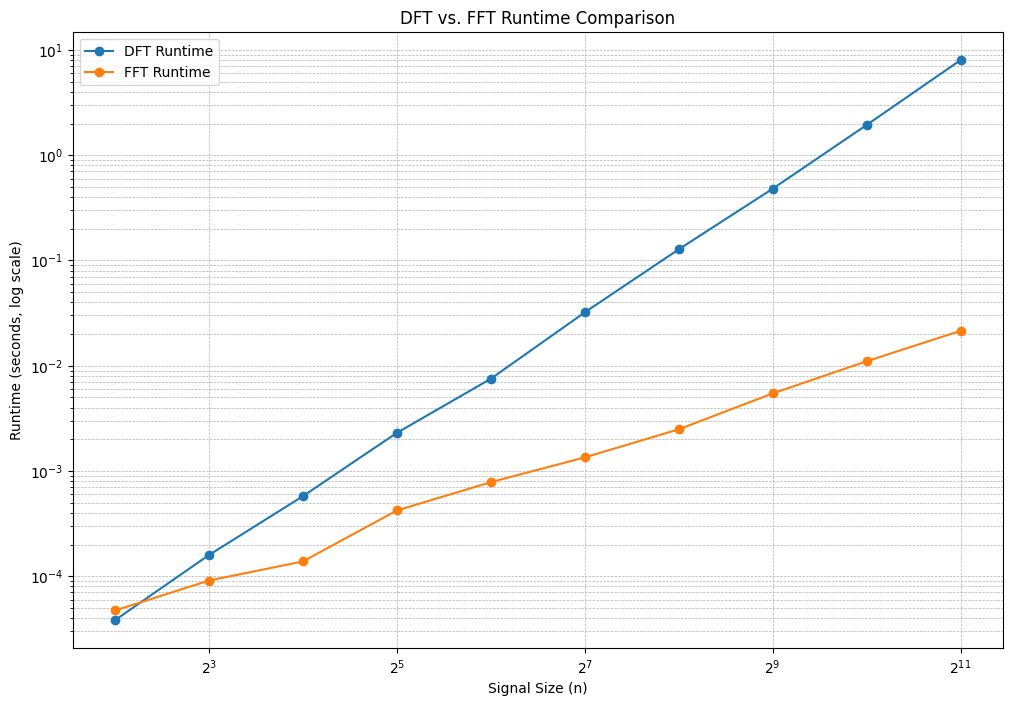

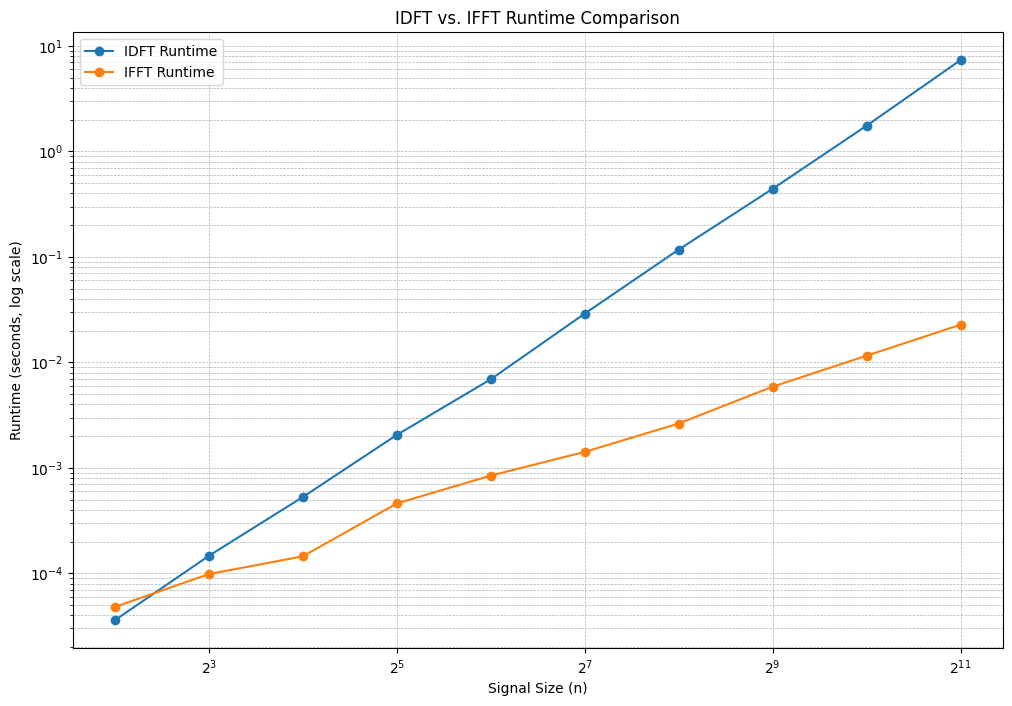

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Signal generation
def generate_random_signal(size):
    return np.random.rand(size)

# Parameters
signal_sizes = [2**k for k in range(2, 12)]  # Sizes: 2^2 to 2^11
#dft_signal_sizes = signal_sizes[:7]          # Limit DFT/IDFT to 2^2 to 2^8

# Pre-generate signals for all sizes
signal_data = {size: generate_random_signal(size) for size in signal_sizes}

# Runtime storage
dft_runtimes = []
idft_runtimes = []
fft_runtimes = []
ifft_runtimes = []

# Number of runs for averaging
num_runs = 50

# Functions for DFT and IDFT (inefficient implementations for comparison)
def dft(signal):
    N = len(signal)
    return np.array([sum(signal[k] * np.exp(-2j * np.pi * k * n / N) for k in range(N)) for n in range(N)])

def idft(signal):
    N = len(signal)
    return np.array([sum(signal[k] * np.exp(2j * np.pi * k * n / N) for k in range(N)) for n in range(N)]) / N

# FFT and IFFT (optimized implementations)
def fft(signal):
    N = len(signal)
    if N <= 1:
        return signal
    if N % 2 != 0:
        raise ValueError("Signal size must be a power of 2 for this FFT implementation.")
    even = fft(signal[::2])
    odd = fft(signal[1::2])
    terms = np.exp(-2j * np.pi * np.arange(N // 2) / N) * odd
    return np.concatenate([even + terms, even - terms])

def ifft(signal):
    N = len(signal)
    if N <= 1:
        return signal
    if N % 2 != 0:
        raise ValueError("Signal size must be a power of 2 for this IFFT implementation.")
    even = ifft(signal[::2])
    odd = ifft(signal[1::2])
    terms = np.exp(2j * np.pi * np.arange(N // 2) / N) * odd
    return (np.concatenate([even + terms, even - terms]) / 2)

# Measure runtimes for DFT and IDFT
for size in signal_sizes:
    dft_times = []
    idft_times = []
    signal = signal_data[size]

    for _ in range(num_runs):
        # Measure DFT runtime
        start_time = time.perf_counter_ns()
        dft_output = dft(signal)
        dft_times.append(time.perf_counter_ns() - start_time)

        # Measure IDFT runtime
        start_time = time.perf_counter_ns()
        idft_output = idft(dft_output)
        idft_times.append(time.perf_counter_ns() - start_time)

    # Store average runtimes (convert ns to seconds)
    dft_runtimes.append(np.mean(dft_times) / 1e9)
    idft_runtimes.append(np.mean(idft_times) / 1e9)

# Measure runtimes for FFT and IFFT
for size in signal_sizes:
    fft_times = []
    ifft_times = []
    signal = signal_data[size]

    for _ in range(num_runs):
        # Measure FFT runtime
        start_time = time.perf_counter_ns()
        fft_output = fft(signal)
        fft_times.append(time.perf_counter_ns() - start_time)

        # Measure IFFT runtime
        start_time = time.perf_counter_ns()
        ifft_output = ifft(fft_output)
        ifft_times.append(time.perf_counter_ns() - start_time)

    # Store average runtimes (convert ns to seconds)
    fft_runtimes.append(np.mean(fft_times) / 1e9)
    ifft_runtimes.append(np.mean(ifft_times) / 1e9)

# Plot DFT vs FFT
plt.figure(figsize=(12, 8))
plt.plot(signal_sizes, dft_runtimes, label="DFT Runtime", marker='o')
plt.plot(signal_sizes, fft_runtimes, label="FFT Runtime", marker='o')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel("Signal Size (n)")
plt.ylabel("Runtime (seconds, log scale)")
plt.title("DFT vs. FFT Runtime Comparison")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Plot IDFT vs IFFT
plt.figure(figsize=(12, 8))
plt.plot(signal_sizes, idft_runtimes, label="IDFT Runtime", marker='o')
plt.plot(signal_sizes, ifft_runtimes, label="IFFT Runtime", marker='o')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel("Signal Size (n)")
plt.ylabel("Runtime (seconds, log scale)")
plt.title("IDFT vs. IFFT Runtime Comparison")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


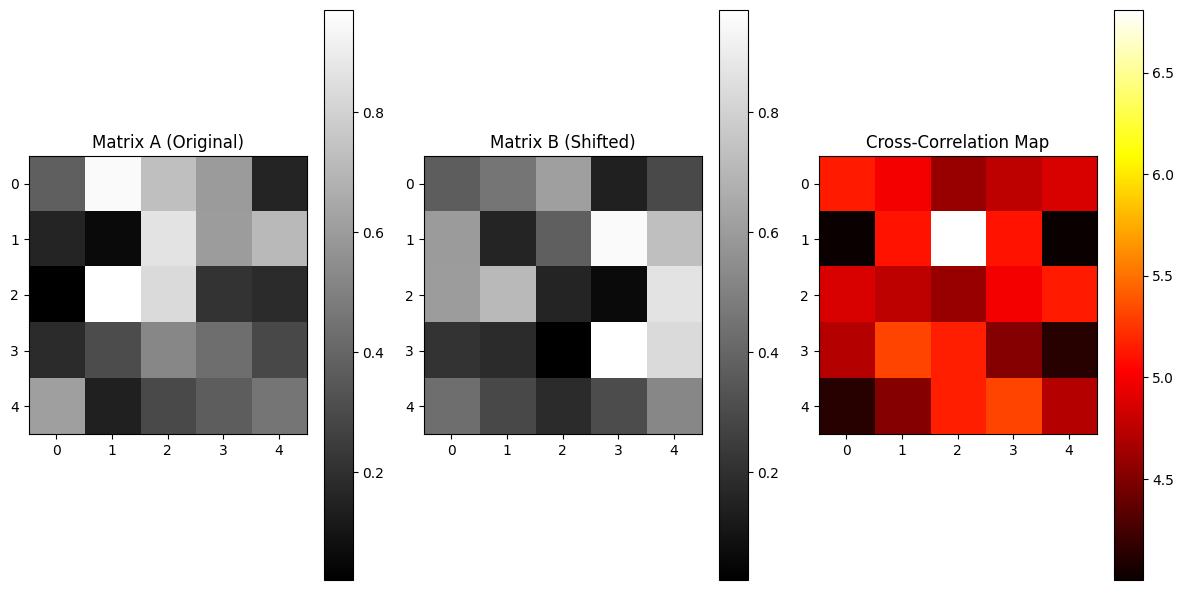

In [11]:
import numpy as np

def idft_2d(freq_domain):
    """Compute the Inverse Discrete Fourier Transform (IDFT) for 2D matrices."""
    rows, cols = freq_domain.shape
    idft_output = np.zeros((rows, cols), dtype=complex)
    
    for n in range(rows):
        for m in range(cols):
            for k in range(rows):
                for l in range(cols):
                    idft_output[n, m] += freq_domain[k, l] * np.exp(2j * np.pi * ((k * n) / rows + (l * m) / cols))
    return idft_output / (rows * cols)


def dft_2d(space_domain):
    """Compute the Discrete Fourier Transform (DFT) for 2D matrices."""
    rows, cols = space_domain.shape
    dft_output = np.zeros((rows, cols), dtype=complex)
    
    for k in range(rows):
        for l in range(cols):
            for n in range(rows):
                for m in range(cols):
                    dft_output[k, l] += space_domain[n, m] * np.exp(-2j * np.pi * ((k * n) / rows + (l * m) / cols))
    return dft_output


def cross_correlation_2d(matrix_A, matrix_B):
    """
    Compute the cross-correlation of two 2D matrices using DFT and IDFT.
    
    Parameters:
        matrix_A (np.ndarray): First 2D matrix.
        matrix_B (np.ndarray): Second 2D matrix.
        
    Returns:
        np.ndarray: Cross-correlation map (2D).
    """
    # Step 1: Compute the DFT of both matrices
    dft_A = dft_2d(matrix_A)
    dft_B = dft_2d(matrix_B)
    
    # Step 2: Multiply DFT_B with the conjugate of DFT_A
    cross_corr_freq = dft_B * np.conj(dft_A)
    
    # Step 3: Perform the inverse DFT to get the cross-correlation map
    cross_corr_map = idft_2d(cross_corr_freq)
    
    return np.real(cross_corr_map)  # Return only the real part


# Example usage with random 2D matrices
np.random.seed(42)
matrix_A = np.random.rand(5, 5)  # Simulated 2D matrix (image)
matrix_B = np.roll(np.roll(matrix_A, shift=1, axis=0), shift=2, axis=1)  # Shifted version of matrix_A

# Step 4: Compute cross-correlation
correlation_map = cross_correlation_2d(matrix_A, matrix_B)

# # Step 5: Find the peak (lag)
# peak = np.unravel_index(np.argmax(correlation_map), correlation_map.shape)
# row_shift = peak[0] - matrix_A.shape[0] // 2
# col_shift = peak[1] - matrix_A.shape[1] // 2
# print(f"Peak correlation at: {peak} (Row shift: {row_shift}, Column shift: {col_shift})")

# Step 6: Display results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Matrix A
plt.subplot(1, 3, 1)
plt.imshow(matrix_A, cmap="gray")
plt.title("Matrix A (Original)")
plt.colorbar()

# Plot Matrix B
plt.subplot(1, 3, 2)
plt.imshow(matrix_B, cmap="gray")
plt.title("Matrix B (Shifted)")
plt.colorbar()

# Plot the Cross-Correlation Map
plt.subplot(1, 3, 3)
plt.imshow(correlation_map, cmap="hot")
plt.title("Cross-Correlation Map")
plt.colorbar()

plt.tight_layout()
plt.show()


54.598150033144236


array([3.71989370e-48, 3.72026571e-48, 3.72063775e-48, ...,
       9.99751031e-05, 9.99851011e-05, 9.99951002e-05])

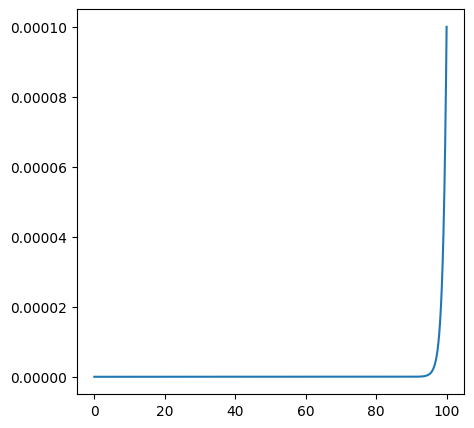

In [93]:
import numpy as np
import matplotlib.pyplot as plt

a=np.linspace(0,100, 1000000)

b=np.power(a,2)

s=np.exp(a)/np.sum(np.exp(a[:]))

plt.figure(figsize=(5,5))

plt.plot(a,s)

c=4

d= np.exp(c)

print(d)

s


In [94]:
import numpy as np

a=np.array([1,2,3,34,4,5,6,677,56,5,75,67,56,75,65432,31,2346,4])
b=a.reshape(2,9)

print(a,b)
print(a.size)
a


[    1     2     3    34     4     5     6   677    56     5    75    67
    56    75 65432    31  2346     4] [[    1     2     3    34     4     5     6   677    56]
 [    5    75    67    56    75 65432    31  2346     4]]
18


array([    1,     2,     3,    34,     4,     5,     6,   677,    56,
           5,    75,    67,    56,    75, 65432,    31,  2346,     4])

C:\Users\shams\AppData\Local\Temp\ipykernel_1516\1115627910.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt1.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_1516\1115627910.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt2.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_1516\1115627910.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt3.legend()


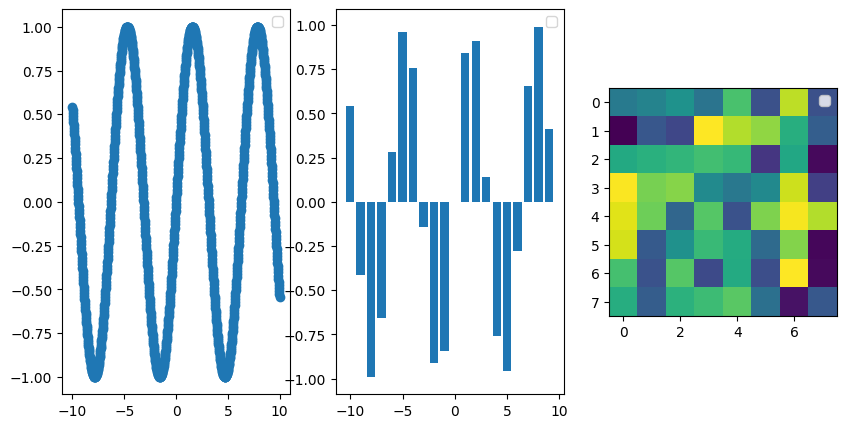

In [95]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs= plt.subplots(1, 3, figsize=(10,5))

plt1=axs[0]

x=np.linspace(-10,10, 1000)
#plt1.figure(figsize=(10,5))
plt1.scatter(x, np.sin(x))
plt1.legend()

plt2=axs[1]

x=np.arange(-10, 10, 1)
#plt2.figure(figsize=(10,5))
# plt.plot(x, np.sin(x))
plt2.bar(x, np.sin(x))
plt2.legend()

plt3=axs[2]

x=np.random.uniform(0,5,(8,8))
plt3.imshow(x)
plt3.legend()

plt.show()


In [104]:
import numpy as np

# a = np.array([0, 2, 4, 6, 8, 10])
# b = np.array([1, 3, 5, 7, 9])

# np.hsplit(a,2)

# a=np.arange(10).reshape(2,5)

# a[1]=a[1][::-1]

# a.T
# # print(a)
# # np.ravel(a)

# b=np.arange(10).reshape(5,2)
# b

# a=np.array([[1,2,3,4],
#    [5,6,7,8],
#    [9,10,11,12],
#    [13,14,15,16]])

# b=np.hstack((np.ravel(a[::2].T), np.ravel(a[1::2].T)))

# np.sum(a, axis=1)

# np.vsplit(a,2)

a=np.array([[11,2,3],
           [4,51,6]])
b=np.array([[10],
           [20]])
# np.hstack((a,b))

# np.sort(a, axis=0)

np.ravel(a.T)

a[-1, :]=a[-1,:][::-1]
a[-1, :]







#np.ravel(np.vstack((a, b)).T)



array([ 6, 51,  4])

C:\Users\shams\AppData\Local\Temp\ipykernel_7724\1520191565.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_7724\1520191565.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_7724\1520191565.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_7724\1520191565.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.l

np.float64(22026.465794806718)

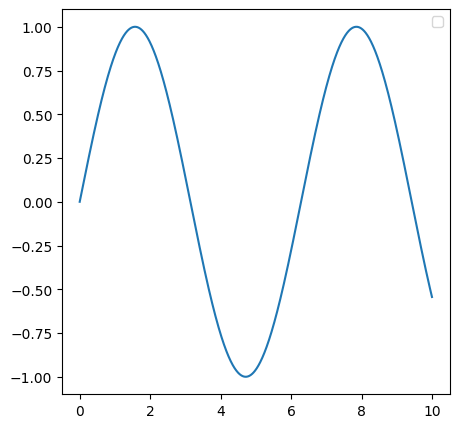

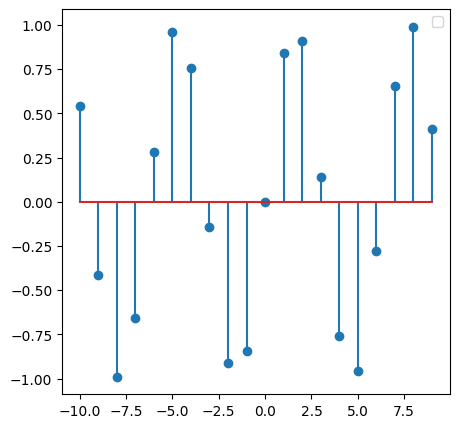

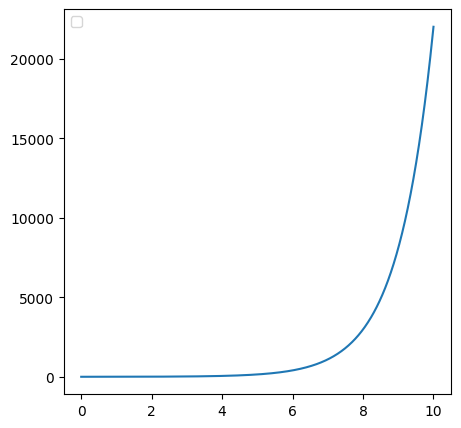

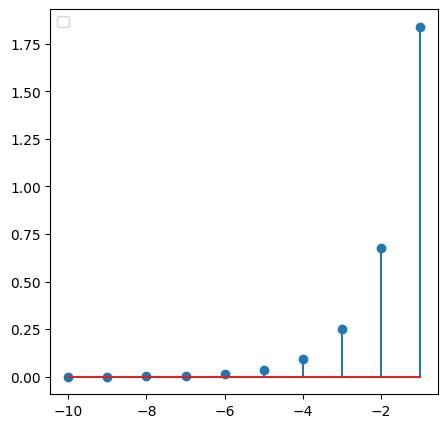

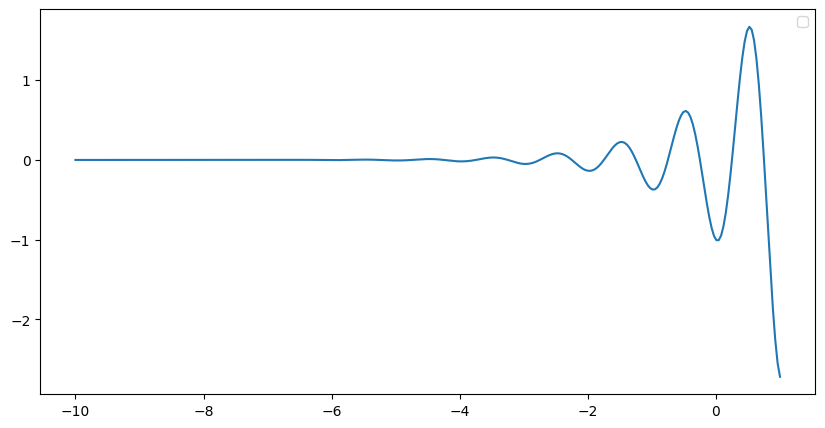

In [34]:
import numpy as np
import matplotlib.pyplot as plt

#sin curve continous

x=np.linspace(0,10, 1000)

plt.figure(figsize=(5,5))
plt.plot(x, np.sin(x))
plt.legend()

#sin curve discrete

x=np.arange(-10, 10, 1)

plt.figure(figsize=(5,5))
plt.stem(x, np.sin(x))
plt.legend()

#exp continous

x=np.linspace(0,10, 1000)

plt.figure(figsize=(5,5))
plt.plot(x, np.exp(x))
plt.legend()

#exp discrete

x=np.arange(-10, 0 , 1)

plt.figure(figsize=(5,5))
plt.stem(x, 5*np.exp(x))
plt.legend()

np.exp(10)


#exp sin

x=np.linspace(-10, 1, 300)

plt.figure(figsize=(10,5))
# plt.plot(x, np.exp(x)*np.cos(2*np.pi*x), "--")
# plt.plot(x, np.exp(x))
# plt.plot(x, -np.exp(x))


# plt.plot(x, -np.exp(x)*np.cos(2*np.pi*x), "--")


#plt.plot(x, np.exp(-x)*np.cos(-2*np.pi*x), "--")

plt.plot(x, -np.exp(x)*np.cos(2*np.pi*x))
plt.legend()

np.exp(10)








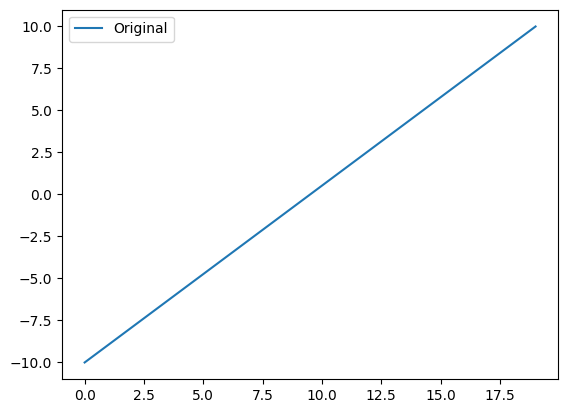

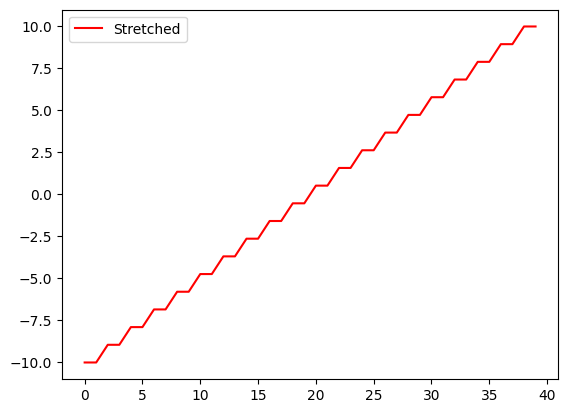

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def time_stretching(x: np.ndarray, factor: int) -> np.ndarray:
    """
    Stretches the array by repeating each element, effectively slowing down the signal.
    
    Parameters:
        x (np.ndarray): Input array.
        factor (int): The stretching factor (greater than 1 stretches the array).
    
    Returns:
        np.ndarray: Stretched array.
    """
    return np.repeat(x, factor)  # Repeat each element 'factor' times

# Original data
x_val = np.arange(0, 20, 1)
x = np.linspace(-10, 10, 20)

# Plot original data
plt.figure()
plt.plot(x_val, x, label='Original')
plt.legend()

# Stretching the data
stretched_x = time_stretching(x, 2)  # Stretch by a factor of 2
stretched_x_val = np.arange(0, len(stretched_x))  # New x-values for the stretched array

# Plot stretched data
plt.figure()
plt.plot(stretched_x_val, stretched_x, label='Stretched', color='red')
plt.legend()

plt.show()


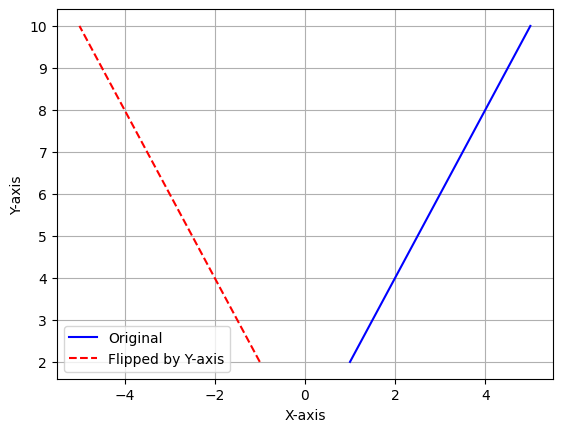

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Original data points
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])

# Flip the graph along the y-axis (negate x-values)
x_flipped = -x

# Plot the original graph
plt.plot(x, y, label="Original", color='blue')

# Plot the flipped graph
plt.plot(x_flipped, y, label="Flipped by Y-axis", color='red', linestyle='--')

# Labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
